# DSCI 572 lecture 7



In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
plt.rcParams['font.size'] = 16

In [3]:
%autosave 0

Autosave disabled


### 1D signals: sequences

- In the 1D case, the signals are _sequences_ (or timeseries).
- A sequence is a series of numbers, like $[0.2, 0.3, -0.15, 0.05, \ldots]$; we store it as a 1D numpy array.
- It's not a vector because its elements are _ordered_.
- If you had

In [4]:
x = [0.2, 0.3, -0.15, 0.05, 0.5]

you could make a plot out of it

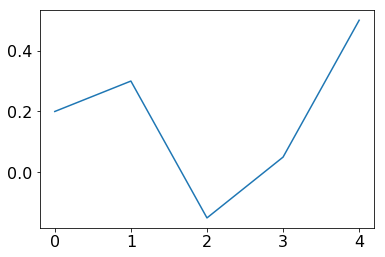

In [5]:
plt.plot(x);

- But at the end of the day, it's just a sequence of numbers.
- You saw diagrams like this in the lecture video on convolutions: we turn a sequence of numbers into a plot.

### 1D signals _with multiple features_

- Let's say that the sequences are stepping over time. E.g. temperature each day in Vancouver.
- Well, what if we measure more than just temperature, e.g. wind speed, rainfall, etc.
- We might get a _vector of measurements_, or in other words a _vector of features_, every day.

| Day | Temp | Wind speed | Rainfall |
|-----|-----|---------------|-------|
|  1   | 20  | 0           |   0 |
|  2   | 10  |  5           | 4  |
|  3    | 12  | 6          |  4 |
|  4    |  12 |  1         |  0 |
| ...  | ...  | ... | ... |

We can encode this as

In [6]:
day1 = [20,0,0]
day2 = [10,5,4]
day3 = [12,6,4]
day4 = [12,1,0]

In [7]:
x = np.vstack((day1,day2,day3,day4))
x

array([[20,  0,  0],
       [10,  5,  4],
       [12,  6,  4],
       [12,  1,  0]])

- You can think of this as 3 sequences (temp sequence, wind speed sequence, rainfall sequence), or as one sequence of 3D vectors. 
  - For today, let's go with the latter.
- This means _each training example is a sequence of vectors or, in other words, a 2D array_
  - This is a big departure from what we're used to, where each training example is a vector (1D array).
- Now, if we want to store our entire dataset in one variable, it's a 3D array: (number of training examples) $\times$ (number of steps in sequence) $\times$ (number of features). Before, $X$ was just 2D, with dimensions $n \times d$. Let's use $T$ to denote the number of steps. So then $X$ is $n \times T \times d$.

In [8]:
# df = pd.DataFrame({'Temp': [20,10,12,12], 'Wind-speed': [0,5,6,1], 'Rainfal': [0,4,4,0]})
# df.index.name="Day"
# df

### 1D convnets: `Conv1D` layer

High level overview: a `Conv1D` layer transforms an example (roughly) from $T \times d_0$ to $T \times d_1$. This is like a `Dense` layer (from $d_0$ to $d_1$), but with this extra $T$ dimension along for the ride.

Important point: with CNNs, **the filters are the paramameters we're learning** (aka weights).

- In a 1D convolutional layer, you have some number of filters (a hyperparameter).
- Each filter has a size (a hyperparameter), which is the same for all filters in the layer.

Example: 5 filters, each of size 3. The signals are of length 100. **We're going from 1 feature to 5 features.**

In symbols, $d_0=1$, $d_1=5$, $T=100$, and $k_0=3$ (let's use $k$ to denote the filter sizes).


In [9]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,1), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 5)            20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.get_weights()[0].shape

(3, 1, 5)

In [11]:
model.get_weights()[0][:,0,:].T

array([[ 0.03636944,  0.57563806, -0.2035487 ],
       [-0.01211065, -0.38784015, -0.13898444],
       [ 0.44900608,  0.5190017 , -0.5741043 ],
       [-0.25224194,  0.07603139,  0.32813543],
       [ 0.16322011, -0.55219245,  0.23620212]], dtype=float32)

Above: 5 filters, each of length 3. We don't have a 3rd dimension because there's only 1 input feature. (The values themselves are just random numbers.)

Let's use this to perform the convolutions.

In [12]:
x = np.sin(np.linspace(0,3,100)) + np.random.randn(100)*0.1

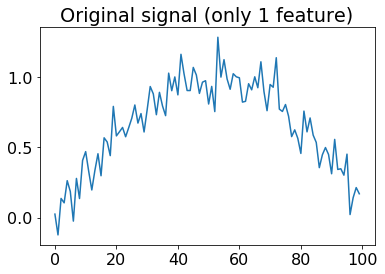

In [13]:
plt.plot(x);
plt.title("Original signal (only 1 feature)");

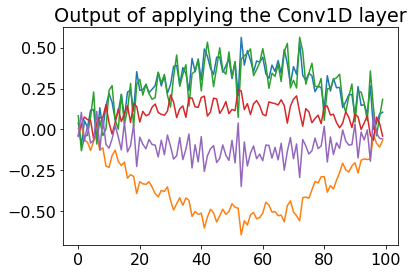

In [14]:
out_example = model.predict(x[None,:,None])
plt.plot(out_example[0]);
plt.title("Output of applying the Conv1D layer");

Above: this is showing the original (black), and 5 different sequences resulting from convolutions of the original sequence with the 5 different length-3 filters.

- Ok, great, so that's what a convolutional layer does!
- (Below) you can also visualize this as a heatmap.

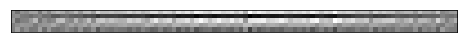

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(out_example[0].T, cmap='gray');
plt.xticks(());
plt.yticks(());

In [16]:
out_example.shape

(1, 100, 5)

- Above: shape is $n \times T \times k_1$.
- These are the "activations" -- the circles in our circle/arrow diagram. 
- Again, we have one extra dimension compared to what we're used to.

Another example, with $d_0=2$.

In [17]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 100, 5)            35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.get_weights()[0].shape

(3, 2, 5)

In [19]:
model.get_weights()[0]

array([[[-0.1352022 ,  0.39935172,  0.04372251,  0.10848147,
          0.47556728],
        [ 0.00470549, -0.03440601, -0.331475  ,  0.19124973,
          0.5060392 ]],

       [[ 0.02004707, -0.49916232, -0.4031093 , -0.25565106,
          0.08434492],
        [ 0.09825772,  0.03796208, -0.46811855,  0.5281324 ,
         -0.3875839 ]],

       [[ 0.4757977 , -0.33811334,  0.06033182, -0.14806142,
         -0.08295763],
        [-0.44179934, -0.12323445,  0.34799618, -0.39562947,
         -0.16365385]]], dtype=float32)

![](Conv1D.png)

**Some key points here:** 

- Each "arrow" in our diagram is now a filter of length 3
- We are going from 2 features to 5 features
- Before, that would mean a $5\times 2$ matrix or 10 parameters (or $2\times 5$ in the convention Keras  uses)
- Now, it means a $3 \times 2\times 5$ matrix or 30 parameters because we have 10 arrows, each a length-3 filter.
  - Plus 5 biases; we still have one bias per "circle" in our diagram, except the input layer
  - Our parameters live in a 3D array or "tensor", NOT a matrix.
  - (The biases are still in a vector, or 1D array.)
- In fully connected neural networks, a $5\times 2$ matrix "consumes" the length-2 dimension (by summing over it), and leaves you only with the length-5 dimension.
- The same thing happens here: the length-2 dimension was consumed, and a length-5 dimension appeared instead. The sequence dimension (length 100) comes along for the ride. 

In [20]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [21]:
model.predict(x).shape

(1, 100, 5)

Another example: more training examples:

In [22]:
X = np.random.rand(1000,100,2)
X.shape

(1000, 100, 2)

$n=1000,T=100,d_0=2$

In [23]:
out = model.predict(X)
out.shape

(1000, 100, 5)

Note: this time **I did not need a new Keras model**. The architecture is the same, I just passed in multiple training examples. !!!

Example: 2 layers

In [2]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same', activation='relu'))
#                ^d_1           ^k_0            ^T  ^d_0 

model.add(Conv1D(4, kernel_size=7, padding='same', activation='relu'))
#                ^d_2           ^k_1

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 5)            35        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 4)            144       
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________


- Above: In general we want a nonlinear activation function applied at every layer.
- I sometimes skip it in this lecture, just to reduce the amount of code you're reading.

In [3]:
model.get_weights()[0].shape # 1st layer filters

(3, 2, 5)

In [4]:
model.get_weights()[1].shape # 1st layer biases

(5,)

In [5]:
model.get_weights()[2].shape # 2nd layer filters

(7, 5, 4)

In [6]:
model.get_weights()[3].shape # 2nd layer biases

(4,)

- Below: here is the circle/arrow diagram for this 2-layer network.
- Just like with fully-connected networks, the output of one layer becomes the input of the next layer.

![](Conv1D_2layers.png)

### 1D convnets: implementation (optional)

- Below are some numpy implementations _of a single layer_.
- We'll ignore biases and activation functions; this is just the linear step.
- We'll show several implementations for FCN (fully connected network) and the CNN.

In [29]:
W = np.random.randn(5,2)
x = np.random.rand(2)

In [30]:
def FCN_layer(W, x):
    return W@x

FCN_layer(W,x)

array([ 1.31810787, -0.10238282, -0.46990932,  0.15799948,  0.73103518])

In [31]:
def FCN_layer_loop(W, x):
    out_dim, in_dim = W.shape # get the shapes
    out = np.zeros(out_dim)   # initialize the output vector
    for i in range(out_dim):  # loop through each output circle in our circle/arrow diagram
        out[i] = W[i]@x       # dot product between x and a row of W 
    return out

FCN_layer_loop(W,x)

array([ 1.31810787, -0.10238282, -0.46990932,  0.15799948,  0.73103518])

In [32]:
def FCN_layer_loop_full(W, x):
    out_dim, in_dim = W.shape # get the shapes
    out = np.zeros(out_dim)   # initialize the output vector
    for i in range(out_dim):  # loop through each output circle in our circle/arrow diagram
        for j in range(in_dim):  # loop through each input circle in our circle/arrow diagram
            out[i] += W[i,j]*x[j]  # multiply x[j] and W[i,j]; this is an arrow in our circle/arrow diagram
    return out


FCN_layer_loop_full(W,x)

array([ 1.31810787, -0.10238282, -0.46990932,  0.15799948,  0.73103518])

In [33]:
model = Sequential()
model.add(Dense(5, input_dim=2))
model.set_weights((W.T, np.zeros(5)))
model.predict(x[None])[0]

array([ 1.3181078 , -0.10238278, -0.46990925,  0.1579994 ,  0.7310352 ],
      dtype=float32)

- Bam!
- The point of the above is to break down the neural network into its most basic operations, multiplication and addition.
- To me, the first two are more intuitive, and the last one is a bit confusing.
- Now let's do that with a CNN, but in the opposite order (fully looped first).
- Again, this is just one layer, not a full network.

In [34]:
W = np.random.rand(3,5,2) # k x d_1 x d_0
x = np.random.rand(10,2)  # T x d_0

In [35]:
def CNN_layer_loop_full(W,x):
    filter_size, out_dim, in_dim = W.shape
    T = x.shape[0]
    T = T - filter_size + 1 # boundary stuff
    
    W_flip = W[::-1] # flip the filters to correspond with how Keras does things (no flipping)

    out = np.zeros((T, out_dim))
    for i in range(out_dim):
        for j in range(in_dim):
            out[:,i] += scipy.signal.convolve(x[:,j],W_flip[:,i,j], mode='valid')
    
    return out

CNN_layer_loop_full(W,x)

array([[2.10959599, 1.39449188, 1.93319681, 1.40797914, 2.19395056],
       [1.81046564, 1.20496765, 1.34847631, 1.37088129, 1.30173593],
       [1.96142172, 1.1447291 , 1.5608164 , 1.42502714, 1.89348242],
       [1.60197559, 0.95124959, 1.0204156 , 1.10045471, 1.17610456],
       [1.84972946, 1.15979877, 1.46287171, 1.04284343, 1.66245912],
       [1.36420965, 0.88727423, 1.22613505, 1.02684216, 1.15407147],
       [1.31903888, 0.86451234, 1.22015501, 1.08013831, 1.13503814],
       [1.39847711, 1.01580112, 1.00947694, 0.96883398, 1.41453306]])

Below: a Conv1D layer can also be implemented cleverly with a 2D convolution, but this is more likely to confuse than to be helpful...

In [36]:
# WARNING: potentially confusing, read at your own risk!
# It's quite elegant that one can do this with a single loop though.
def CNN_layer_loop(W,x):
    filter_size, out_dim, in_dim = W.shape
    T = x.shape[0]
    T = T - filter_size + 1 # boundary stuff
    
    W_flip = W[::-1,:,::-1] # flip the filters to correspond with how Keras does things (no flipping)

    out = np.zeros((T, out_dim))
    for i in range(out_dim):
        out[:,i] = scipy.signal.convolve2d(x,W_flip[:,i,:], mode='valid')[:,0] 
    return out

CNN_layer_loop(W,x)

array([[2.10959599, 1.39449188, 1.93319681, 1.40797914, 2.19395056],
       [1.81046564, 1.20496765, 1.34847631, 1.37088129, 1.30173593],
       [1.96142172, 1.1447291 , 1.5608164 , 1.42502714, 1.89348242],
       [1.60197559, 0.95124959, 1.0204156 , 1.10045471, 1.17610456],
       [1.84972946, 1.15979877, 1.46287171, 1.04284343, 1.66245912],
       [1.36420965, 0.88727423, 1.22613505, 1.02684216, 1.15407147],
       [1.31903888, 0.86451234, 1.22015501, 1.08013831, 1.13503814],
       [1.39847711, 1.01580112, 1.00947694, 0.96883398, 1.41453306]])

In [37]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(10,2)))
model.set_weights((np.swapaxes(W,1,2), np.zeros(5)))
model.predict(x[None])[0]

array([[2.1095958 , 1.3944919 , 1.9331968 , 1.4079791 , 2.1939507 ],
       [1.8104656 , 1.2049676 , 1.3484763 , 1.3708812 , 1.301736  ],
       [1.9614217 , 1.1447291 , 1.5608164 , 1.4250271 , 1.8934823 ],
       [1.6019756 , 0.9512496 , 1.0204157 , 1.1004548 , 1.1761045 ],
       [1.8497294 , 1.1597989 , 1.4628718 , 1.0428435 , 1.6624591 ],
       [1.3642095 , 0.8872742 , 1.226135  , 1.0268421 , 1.1540715 ],
       [1.3190389 , 0.8645123 , 1.220155  , 1.0801382 , 1.1350381 ],
       [1.3984771 , 1.0158012 , 1.009477  , 0.96883404, 1.4145331 ]],
      dtype=float32)

- Above: we get the same results with a Keras `Conv1D` layer. 
- So from the above you can see what this layer is doing.
- The most useful comparison is probably `FCN_layer_loop_full` and `CNN_layer_loop_full`.
  - FCN inner loop: **an activation (number) multiplied by a weight (number)** .
  - CNN inner loop: **a signal (array) convolved with a filter (array)**.
  - The rest of the code is basically the same.
- This exercise could be easily extended to a `Conv2D` layer - if you're bored, give it a try!

### 1D convnets: pooling with `MaxPooling1D`

In [38]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 100, 5)            35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [39]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [40]:
out = model.predict(x)
out.shape

(1, 100, 5)

In [41]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
#                ^d_1           ^k_0            ^T  ^d_0 

model.add(MaxPooling1D(pool_size=2))
#                                ^T is reduced by this factor, i.e. 100 to 50
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 100, 5)            35        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 5)             0         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [42]:
out = model.predict(x)
out.shape

(1, 50, 5)

Two observations:

1. Pooling does not introduce parameters
2. Pooling changes $T$, not $d$; this is the first time we changed $T$

![](Conv1D_and_MaxPooling1D.png)

One other thing: 

- We don't need to keep making an `out` variable, because the summary actually tells us this information. 
- The `None` dimension refers to the number of examples we're passing through at one time. 
  - Doesn't have to be the number of training examples.
  - With SGD this is the minibatch size.
  - At test time this is the number of test examples (maybe just one).
- To reiterate, this is a special dimension! It's not specified by the architecture.


### 1D convnets: flattening with `Flatten`

- Eventually, we usually want to do some regression or classification.
- Say we'd going 10-class classification. Then we want to get from the current state (e.g. $50\times 5$) to just a vector of length 10.
- **We need to lose a whole dimension.**

In [43]:
x = np.random.rand(2,3)
x

array([[0.04735539, 0.97702615, 0.42996062],
       [0.83613648, 0.60914608, 0.17301439]])

In [44]:
x.flatten()

array([0.04735539, 0.97702615, 0.42996062, 0.83613648, 0.60914608,
       0.17301439])

In [45]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 100, 5)            35        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


- Before, the output size was $n\times 50\times 5$ (see output shape of pool layer), now it's $n\times 250$. This is "flattening".
- It's unlikely that the number we get is exactly what we need, so it's customary to include one (or more) `Dense` layers at the end.

### 1D convnets: end-to-end example

In [46]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10)) # for 10-class classification
# one could add more Dense layers here
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 100, 5)            35        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 5)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 7)             112       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 25, 7)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 175)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1760      
Total params: 1,907
Trainable params: 1,907
Non-trainable params: 0
_________________________________________________________________


- Now the convnet is a mapping FROM sequences of length 100, with 2 features per step, TO length-10 vectors (class probabilities).
- For regression we'd just output a number instead.

In [47]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1)) # for regression
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 100, 5)            35        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 5)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 7)             112       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 7)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 175)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 176       
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________


In [48]:
x = np.random.rand(1,100,2) # n=1, T=100, d=2
x.shape

(1, 100, 2)

In [49]:
model.predict(x) # just a number

array([[0.23693988]], dtype=float32)

### 1D convnets: strided convolutions (optional)

- This is a similar idea to pooling.
- Instead of "sliding" the filter over every pixel, you slide it over every 2nd or 3rd pixel.
- This is like deleting every 2nd or 3rd element of the output. 
- Example:

In [50]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 100, 5)            35        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 5)             0         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [51]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, strides=2, input_shape=(100,2), padding='same'))
#                                          ^ go every 2nd entry
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 50, 5)             35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


- Note the output shape is the same, so the architecture is extremely similar. 
- The results would not be identical though (for the same filters!), because with MaxPooling we're taking the max of every 2 outputs, instead of just keeping only the first one. With the right choice of filters, they might end up the same, which essentially makes the architectures equivalent.
- The pros/cons of these two approaches are not super clear to me. 

### 1D convnets: padding (optional)

Aside: if you're wondering why I'm setting `padding='same'` it's because of the boundary issues with convolutions. The default is to only include cases where the filter fully fits on top of the signal, meaning the actual output size is $T - k+1$. But that makes it more confusing when explaining what's going on, becuase the number keeps changing. 

In [52]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 98, 5)             35        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


Above: output size is $98 \times 5$ instead of $100\times 5$

In [53]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.add(Conv1D(7, kernel_size=3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 98, 5)             35        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 96, 7)             112       
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


Above: each convolutional layer reduces the output size by $k-1$.

In [54]:
model = Sequential()
model.add(Conv1D(5, kernel_size=3, input_shape=(100,2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(7, kernel_size=3))
model.add(MaxPooling1D(pool_size=2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 98, 5)             35        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 49, 5)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 47, 7)             112       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 23, 7)             0         
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


Above: it starts to get confusing: we went from 100 to 23.

### 2D signals: images

- A 2D signal is typically called an _image_.
- Here is one:

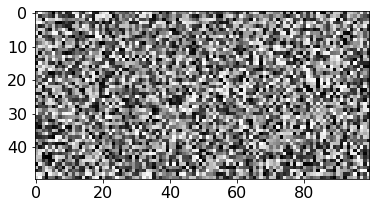

In [55]:
x = np.random.rand(50,100)
plt.imshow(x, cmap="gray");

- I will use $h$ and $w$ to denote the height and width; this is instead of $T$ for the filter length.
- The above image has size $h=50,w=100$.

#### Multiple channels

- As with the 1D case, you might have multiple features _per point in the signal_.
- A very common situation with images is to have 3 colour channels.

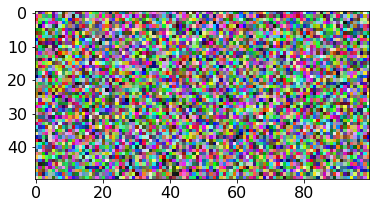

In [56]:
x = np.random.rand(50,100,3)
plt.imshow(x);

- In fact, _channel_ is the general term typically used here, rather than feature.
- I will continue using $d$ to denote the number of channels (aka features).
- The above image has size $h=50,w=100,d=3$.

In [57]:
milad = plt.imread("milad.jpg")
milad.shape

(756, 506, 3)

- Above: 3 colour channels again.
- But 2D CNNs work with any number of channels. 
- In practice, another commonly occuring case is $d=1$ for grayscale images (e.g. electron microscope images, MNIST digits).

### 2D convnets: `Conv2D` layer

In [58]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(11,11), input_shape=(milad.shape[0],milad.shape[1],3), padding='same', activation='sigmoid'))
#                ^d_1            ^k_0               ^h             ^w             ^d_0 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 756, 506, 5)       1820      
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


In [59]:
out = model.predict(milad[None])
out.shape

(1, 756, 506, 5)

![](Conv2D.png)

- Critically, note that the number of parameters does not depend on the input image size (e.g. $50\times 100$).
- This is why the number of parameters is so much less than a fully connected network applied to a flattened image.
- The number of parameters will eventually be affected by the input image size, at a later layer (see below).

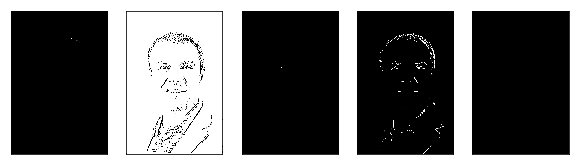

In [60]:
def make_plots(arr):
    num_plots = arr.shape[-1]
    plt.figure(figsize=(10,6))
    for i in range(num_plots):
        plt.subplot(1,num_plots,i+1);
        outimg = arr[:,:,i]
        plt.imshow((outimg-outimg.min())/(outimg.max()-outimg.min()), cmap='gray')
        plt.xticks(());
        plt.yticks(());

make_plots(out[0])

- What am I looking at here?
- Well, our output shape is $756 \times 506 \times 5$.
- With 1D convnets, our state was a 2D array, which we could draw either as a bunch of sequences or as an image... remember these?

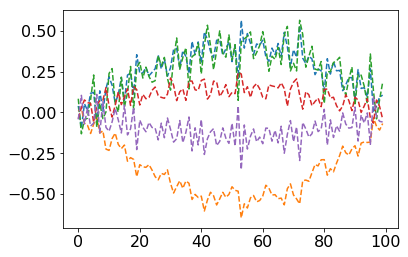

In [61]:
plt.plot(out_example[0], '--');

- Well, now we have an extra dimension. **So each channel is an image instead of a sequence**.
- In both cases we have 5 channels, but we visualize them differently.
- In each of the 5 images above, you're seeing random convolutions applied to each of the channels (which are then summed).
- In fact, we also could have separated out the _original_ image into its channels this way (though it would be weird to do so):

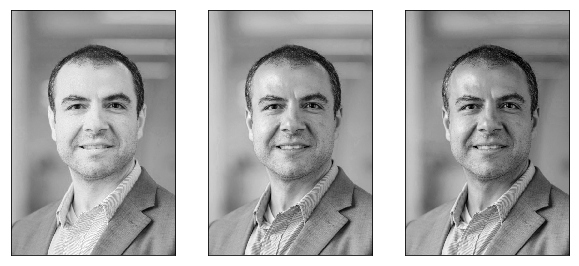

In [62]:
make_plots(milad)

- Above: the red, green, and blue channels of the original milad image.
- Note that his shirt is "brighter" (more white) in the red channel because his shirt is pink.
- **It's important not to confuse these diagrams with having multiple examples; these are multiple channels for a single example.**

#### Warning: do not confuse the filters and the activations; both can be visualized!

- To make matters worse, the filters can also be visualized as images. 

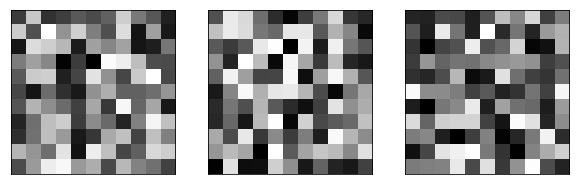

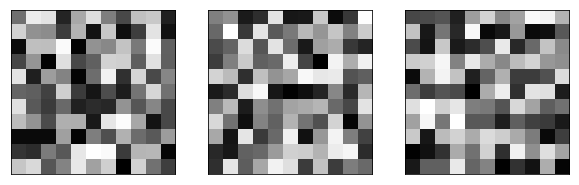

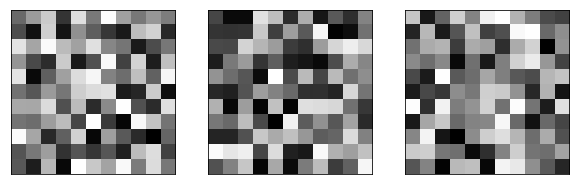

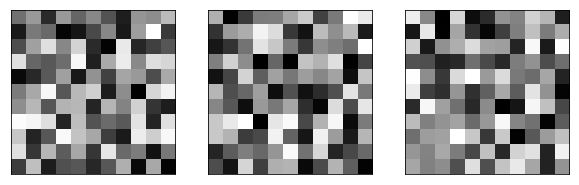

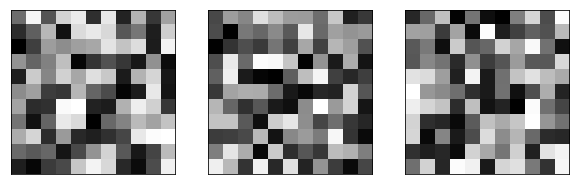

In [63]:
for i in range(5):
    make_plots(model.get_weights()[0][...,i])

- Above: these are the $3\times 5$ random $11\times 11$ filters currently in this `Conv2D` layer.
- This is like the $5 \times 3$ weight matrix from a fully connected network but
  - For 1D convnets, each entry (filter) is a 1D sequence
  - For 2D convnets, each entry (filter) is a 2D image
- Thus, the weight tensor is actually 4D.
- **These are the parameters that you learn with gradient descent or SGD**.

In [64]:
model.get_weights()[0].shape

(11, 11, 3, 5)

- This is (one reason) why people tend to get pretty confused...
- Plus, we have so many numbers to keep track of just for one layer: $d_0=3,d_1=5,k_0=(11,11),h=756,w=506$.
- For a FCN we'd only need the first two!

- Below: here is a schematic diagram of why we need 4 dimensions to represent the parameter tensor ($W$)
- The parameter filled in red is indexed by `W[2,4,0,1]`
- If you need 4 indices to address something, that means you have a 4D array.
- Note: in this case the filters are $3\times 3$ instead of $11\times 11$ to make drawing easier.

![](Conv2D_weight_tensor_4D.png)

### 2D convnets: `MaxPooling2D`

In [65]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(11,11), input_shape=(milad.shape[0],milad.shape[1],3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
#                                ^k is reduced by a factor of 2 in each direction
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 756, 506, 5)       1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 378, 253, 5)       0         
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


Above: this does basically the exact same thing as 1D pooling, except that we are free to choose a separate pool factor for each dimension (but typically use the same one).

BTW it's valid syntax to just specify an integer if you want them all the same, i.e.

In [66]:
model = Sequential()
model.add(Conv2D(5, kernel_size=11, input_shape=(milad.shape[0],milad.shape[1],3), padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 756, 506, 5)       1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 378, 253, 5)       0         
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


- The `11` implies `(11,11)` and the `2` implies `(2,2)`.
- However I suggest not doing this, as it's good to make sure you understand what's happening.
- E.g. going from `kernel_size=10` to `kernel_size=20` doesn't double the number of parameters in the layer, it quadruples it.

### 2D convnets: end-to-end example

- Below is the MNIST model from the lab (minus dropout, for clarity)
- Note that here we don't set `padding='same'` (see optional section above about the padding)
  - This is why the convolution takes the size from $28\times 28$ to $24\times 24$.

In [67]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dense(10, activation='softmax'))

mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________


- This is the point where the image shape factors into the number of parameters:
  - The image shape is propagated through the layers .
  - Here, it's $28\times 28$, then $24\times 24$, then $12\times 12$; then, this gets flattened into $12\times12\times32=4608$ units.
  - The image shape right before the flattening determines the number of parameters of the first dense layer.
  - If we try changing the input shape, you'll see more parameters in the Dense layer, _not_ the Conv2D layer.


In [68]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, (5, 5), input_shape=(50, 50, 1), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dense(10, activation='softmax'))

mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2166912   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 2,169,034
Trainable params: 2,169,034
Non-trainable params: 0
_________________________________________________________________
